Author: Paul Wang

# Overview
This tutorial shows a basic run of the Procrustes subspace adaptation (PSA) algorithm. PSA is an online, unsupervised domain adaptation technique intended for time series regression problems; given a training and test dataset that differ in distribution, PSA finds a common evolving latent space representation of the data by aligning subspaces of the training and test data. A model can be trained in this latent space to produce more accurate predictions on the test dataset.

# Introduction

## Domains and Model Extrapolation
In machine learning, models learn on a set of *training* data and are deployed to predict on a set of *test* data; specifically, these datasets are composed of sampled input/output pairs on which a model processes an input and produces a prediction of the output. Ideally, the training data should be a representative sample of the test data such that the model predicts on the test data with low error. "Representative" means that the sampled training data is similar in *distribution* to the test data, such that the "range" of the sampled model inputs in the training data encompasses that of the test data and the number of samples for different inputs between training and test are roughly equivalent. If the training and test data are similar in distribution, then the model *generalizes* well to the test data when trained only on the training data. Formally, each dataset (i.e., the sampled input and output points) and its associated probability distribution is defined as a "domain".

There's more nuances to discrepancies between training/test data and how models generalize across domains (namely, this definition I introduced only covers a specific type of distribution shift in the inputs called *covariate shift*) but elaborating on this requires expounding on fundamental machine learning theory. I'll list a couple references below in case any reader is interested.

- S. Ben-David, J. Blitzer, K. Crammer, A. Kulesza, F. Pereira, and J. W. Vaughan, “A theory of learning from different domains,” Mach Learn, vol. 79, no. 1–2, pp. 151–175, May 2010, doi: 10.1007/s10994-009-5152-4.
- Y. Mansour, M. Mohri, and A. Rostamizadeh, “Domain Adaptation: Learning Bounds and Algorithms,” Nov. 30, 2023, arXiv:0902.3430. doi: 10.48550/arXiv.0902.3430.
- W. M. Kouw and M. Loog, “An introduction to domain adaptation and transfer learning,” Jan. 14, 2019, arXiv:1812.11806. [Online]. Available: http://arxiv.org/abs/1812.11806

## Domain Adaptation in Machine Learning
If the training and test data are not similar in distribution, then the model *extrapolates* and is inaccurate on the out-of-distribution test data. This is highly undesirable. *Domain adaptation* is a problem in machine learning that aims to adapt a model trained on a *source* domain (i.e., the training data) to a *target* domain (i.e., the test data). If the model has access to both input and output data in the target domain, simply retraining the model (i.e., empirical risk minimization) can mitigate the extrapolation since the model learns from the data in the test set. However, there are some situations where the model has no access to output data and cannot re-train on the target domain. This data is *unlabeled* (i.e., only input data from the test data/target domain are available) and domain adaptation methods that handle unlabeled data are called *unsupervised*.

Numerous past works have handled domain adaptation for classification problems but domain adaptation for regression is still relatively nascent at the time of writing this notebook. Readers might be familiar with adversarial methods to mitigate distribution shifts like generative adversarial nets or domain adversial neural networks, but these approaches were originally intended for image classification and large dimension inputs. The specific problem of interest for this work and notebook are on *physical* problems in modeling, simulation, and analysis of physical systems, where data is often continuous, scalar, and governed by physical laws.

# A Motivating Example

Let's introduce a historical motivating example. On March 10, 2006, the Mars Reconnaissance Orbiter (MRO) began its aerobraking campaign around Mars. Continuously entering and exiting the atmosphere causes repeated thermal loading, potentially burning or melting spacecraft components. Consequently, the MRO mission used a response surface equation (a data-fit model) to calculate the temperature on the spacecraft solar panels. The appeal of using a data-fit model is in its quick inference time for time-critical tasks during aerobraking; a data-fit surrogate model is quicker to evaluate than a high-fidelity, full order finite-element thermal simulation. The model inputs were density, velocity, the thermal emissivity of the solar array, and numerous other variables. The model output was the temperature on the solar array.

I desire to develop a similar model that predicts thermal loading on a reentry vehicle. For simplicity, I'll assume a purely data-fit machine learning model that ingests density and outputs the heat rate applied to the spacecraft; specifically, I seek to learn a function $f:\rho \mapsto \dot{Q}$. From past missions or experiments, I gather a set of data $\{ \rho_i, \dot{Q}_i \}_{i=1}^n$. I intend to deploy this model on a new, extrapolatory mission. My spacecraft will encounter new, unseen atmospheric densities and predict the corresponding heat rates.

# Visualizing the Data
I'll start by importing all dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
from utils import NeuralNetwork
from utils import train_model
import psa

import torch 
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

My trajectory data are within the `data` folder, which I proceed to import as CSVs. I'll call the trajectory data I train on `mission1` and the extrapolatory trajectory I predict on `mission2`. I then plot the density vs. time, the heat rate vs. time, and heat rate vs. density.

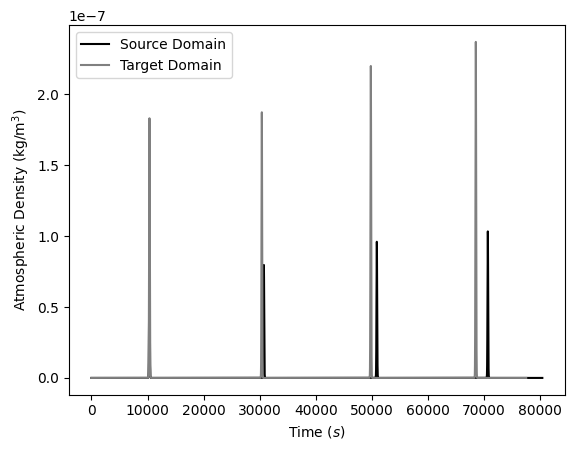

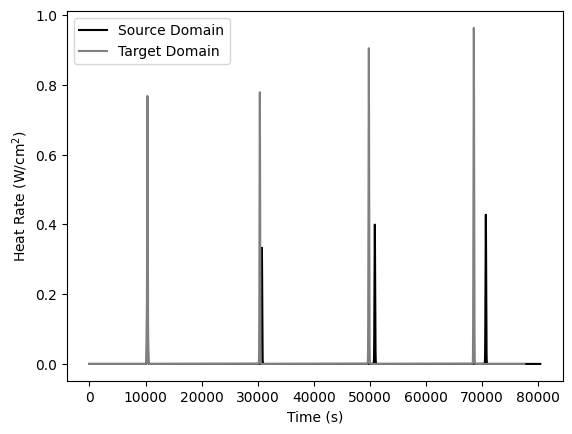

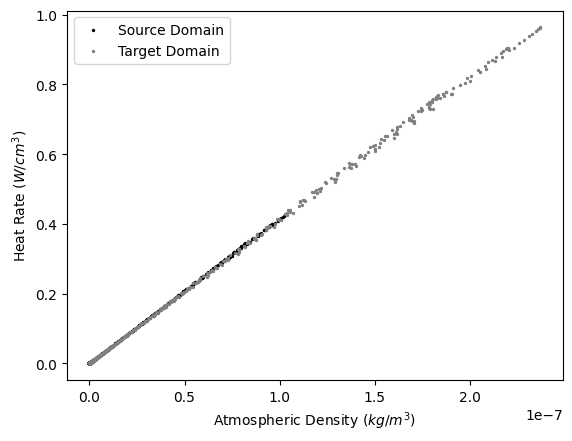

In [2]:
mission1_data_directory = r'data\4orbit_ra=12000_rp=100.0\Results_ctrl=0_ra=12000_rp=100.0_hl=0.150_90.0deg.csv'
mission2_data_directory = r'data\4orbit_ra=12000_rp=95.0\Results_ctrl=0_ra=12000_rp=95.0_hl=0.150_90.0deg.csv'
df1 = pd.read_csv(mission1_data_directory)
df2 = pd.read_csv(mission2_data_directory)

# Plotting
fig1, ax1 = plt.subplots(1,1)
ax1.plot(df1['time'], df1['rho'], label="Source Domain", color='black')
ax1.plot(df2['time'], df2['rho'], label="Target Domain", color='gray')
ax1.set_xlabel('Time ($s$)')
ax1.set_ylabel('Atmospheric Density (kg/m$^3$)') 
ax1.legend()

fig2, ax2 = plt.subplots(1,1)
ax2.plot(df1['time'], df1['heat_rate'], label="Source Domain", color='black')
ax2.plot(df2['time'], df2['heat_rate'], label="Target Domain", color='gray')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Heat Rate (W/cm$^2$)')
ax2.legend() 

# Plotting state space
fig3, ax3 = plt.subplots(1,1)
ax3.scatter(df1['rho'], df1['heat_rate'], s=2, label="Source Domain", color='black')
ax3.scatter(df2['rho'], df2['heat_rate'], s=2, label="Target Domain", color='gray')
ax3.set_xlabel('Atmospheric Density ($kg/m^3$)')
ax3.set_ylabel('Heat Rate ($W/{cm}^3$)') 
ax3.legend()

plt.show()

Not especially surprising, right? Heat rate scales linearly with density, and the heat rate and density both spike in value when the spacecraft reenters the atmosphere and return to zero values when the spacecraft exits into the vacuum of space. 

A key aspect of the data to note is that both density and heat rate vary with time. I'll exploit that aspect to decompose the data with a technique called *singular spectrum analysis*.

# Finding Subspaces with Singular Spectrum Analysis
I'll first introduce some functions.

Text(0, 0.5, '$K$-Lagged Vectors')

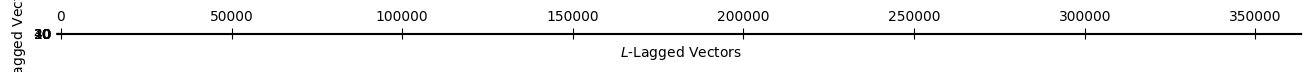

In [ ]:
L = 50 # The window length.
N = len(df1)
K = N - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns
X = np.column_stack([df1[i:i+L] for i in range(0,K)])
# Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive.

ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")

# 